##**Домашнее задание  "Введение в сверточные сети"**

**Задание:** в отдельном файле.

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10.

**Решение:**

## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">


Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [ ]:
import numpy as np
from tensorflow.keras import layers, models, Input
from tensorflow.keras.datasets import cifar10

# Загрузка данных
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


Создание валидационного и обучающего наборов

In [ ]:
from sklearn.model_selection import train_test_split

# Создаем валидационную выборку из обучающего набора
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Проверка размеров после разделения
print("Размер обучающего набора:", x_train.shape[0])  # Ожидаем 40,000
print("Размер валидационного набора:", x_val.shape[0])  # Ожидаем 10,000
print("Размер тестового набора:", x_test.shape[0])      # Ожидаем 10,000

Размер обучающего набора: 40000
Размер валидационного набора: 10000
Размер тестового набора: 10000


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

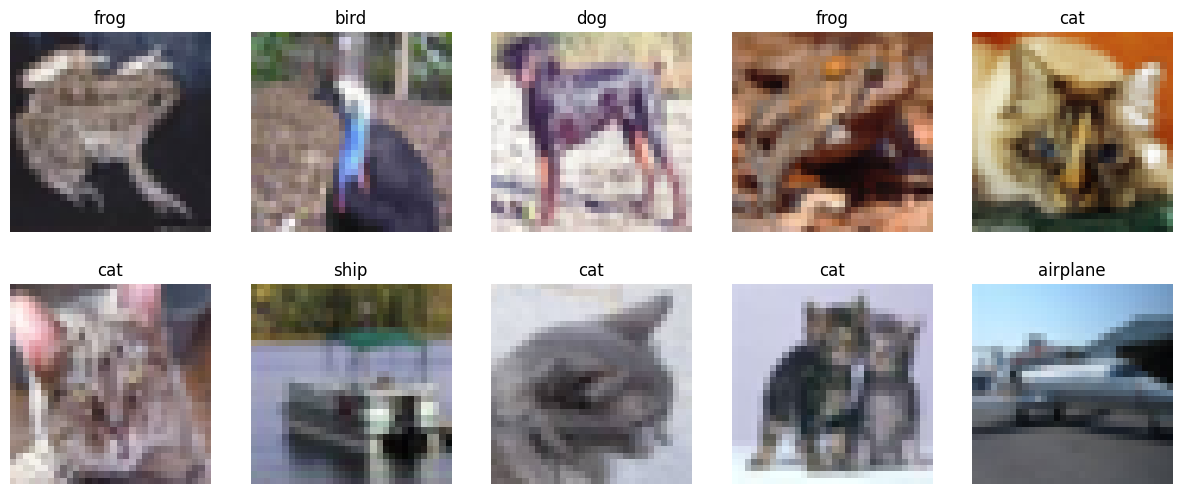

In [ ]:
import matplotlib.pyplot as plt

# Список классов CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Функция для отображения изображений
def plot_images(images, labels, class_names, n=10):
    plt.figure(figsize=(15, 6))
    for i in range(n):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i][0]])  # labels[i][0] потому что y_train имеет форму (n, 1)
        plt.axis('off')
    plt.show()

# Отобразим первые 10 изображений из обучающего набора
plot_images(x_train, y_train, class_names)

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [ ]:
# Нормализация данных
x_train = x_train / 255
x_val = x_val / 255
x_test = x_test / 255

Исполните код ниже для проверки, что все выполнено корректно.

In [ ]:
assert np.shape(x_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (x_train, x_val, x_test))) <= 1.05
assert 0.0 <= min(map(np.min, (x_train, x_val, x_test))) <= 0.1
assert len(np.unique(x_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:




In [ ]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Создание модели
model = models.Sequential([
    Input(shape=(32, 32, 3)),                   # Входной слой
    layers.Flatten(),                            # Преобразование изображения в вектор
    layers.Dense(128, activation='relu'),       # Первый полносвязный слой
    layers.Dense(64, activation='relu'),        # Второй полносвязный слой
    layers.Dense(10, activation='softmax')      # Выходной слой с 10 классами
])

# Компиляция модели с использованием SGD
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

# Вывод структуры модели
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         393,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 402,250 (1.53 MB)

 Trainable params: 402,250 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

## Обучение сети



### **Задание 1.1 (обязательно)**

Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__

поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [ ]:
# Создание EarlyStopping для предотвращения переобучения
early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5, restore_best_weights=True)

# Обучение модели
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=10,  # Настройка количества эпох
                    batch_size=32,  # Размер батча
                    callbacks=[early_stopping],
                    verbose=1)  # Вывод результатов обучения

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 2.0365 - sparse_categorical_accuracy: 0.2548 - val_loss: 1.7998 - val_sparse_categorical_accuracy: 0.3662
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 1.7748 - sparse_categorical_accuracy: 0.3701 - val_loss: 1.8136 - val_sparse_categorical_accuracy: 0.3602
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.6833 - sparse_categorical_accuracy: 0.4051 - val_loss: 1.6621 - val_sparse_categorical_accuracy: 0.4057
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.6238 - sparse_categorical_accuracy: 0.4200 - val_loss: 1.5977 - val_sparse_categorical_accuracy: 0.4285
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 1.5755 - sparse_categorical_accuracy: 0.4387 - val_loss: 1.5609 - val_sparse_categorical_accuracy: 0.4502
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 1.5344 - sparse_categorical_accuracy: 0.4573 - val_loss: 1.5557 - val_sparse_categorical_accuracy

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [ ]:
import pandas as pd

# Создаем DataFrame где будут собраны результаты оценок моделей
results_df = pd.DataFrame(columns=['Model Name', 'Test Loss', 'Test Accuracy'])

In [ ]:
# Оценка модели на тестовом наборе
test_loss, test_accuracy = model.evaluate(x_test, y_test)

# Параметры для конкретной модели
model_name = "MyModel1"

# Добавляем в существующий DataFrame
results_df.loc[0] = [model_name, test_loss, test_accuracy]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.4558 - sparse_categorical_accuracy: 0.4782


In [ ]:
# Выводим таблицу с результатами
print(results_df)

  Model Name  Test Loss  Test Accuracy
0   MyModel1    1.46306         0.4771


Это означает, что модель которая достигнет не менее 45% accuracy на тестовых данных.

## Карманная сверточная сеть



### **Задание 1.2 (обязательно)**

Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [ ]:
import pandas as pd
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

# Создание модели сверточной нейронной сети с использованием Input
cnn_model = models.Sequential()

# Входной слой
cnn_model.add(layers.Input(shape=(32, 32, 3)))  # Явное определение входных данных

# Слой свёртки
cnn_model.add(layers.Conv2D(10, (3, 3), activation='relu'))  # Свёртка 3x3 с 10 фильтрами
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))  # Max-pooling 2x2

# Преобразование в вектор
cnn_model.add(layers.Flatten())

# Полносвязный слой
cnn_model.add(layers.Dense(100, activation='relu'))  # Полносвязный слой на 100 нейронов

# Выходной слой
cnn_model.add(layers.Dense(10, activation='softmax'))  # Выходной слой с softmax

# Компиляция модели
cnn_model.compile(optimizer='sgd',
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

# Вывод структуры модели
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 10)          │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2250)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │         225,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 226,390 (884.34 KB)

 Trainable params: 226,390 (884.34 KB)

 Non-trainable params: 0 (0.00 B)

Обучение

In [ ]:
# Создание EarlyStopping для предотвращения переобучения
early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5, restore_best_weights=True)

# Обучение модели
history = cnn_model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=10,  # Настройка количества эпох
                        batch_size=32,  # Размер батча
                        callbacks=[early_stopping],
                        verbose=1)  # Вывод результатов обучения

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 2.0890 - sparse_categorical_accuracy: 0.2389 - val_loss: 1.7830 - val_sparse_categorical_accuracy: 0.3621
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 1.7193 - sparse_categorical_accuracy: 0.3928 - val_loss: 1.5713 - val_sparse_categorical_accuracy: 0.4469
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 1.5552 - sparse_categorical_accuracy: 0.4474 - val_loss: 1.4827 - val_sparse_categorical_accuracy: 0.4690
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - loss: 1.4571 - sparse_categorical_accuracy: 0.4853 - val_loss: 1.4230 - val_sparse_categorical_accuracy: 0.4920
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 1.3798 - sparse_categorical_accuracy: 0.5113 - val_loss: 1.3762 - val_sparse_categorical_accuracy: 0.5054
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 1.3261 - sparse_categorical_accuracy: 0.5263 - val_loss: 1.3613 - val_sparse_categoric

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [ ]:
# Оценка модели на тестовом наборе
test_loss, test_accuracy = cnn_model.evaluate(x_test, y_test)

# Параметры для конкретной модели
model_name = "CNN_Model1"

# Добавляем результаты в DataFrame
results_df.loc[1] = [model_name, test_loss, test_accuracy]

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.1983 - sparse_categorical_accuracy: 0.5777


In [ ]:
# Выводим таблицу с результатами
print(results_df)

   Model Name  Test Loss  Test Accuracy
0    MyModel1   1.463060         0.4771
1  CNN_Model1   1.212987         0.5697


Согласно результатам оценки модели на тестовых данных, карманная свёрточная сеть достигла точности, которая превышает заданный порог в 50%. То есть модель смогла успешно классифицировать более половины тестовых изображений. Это подтверждает, что даже простая архитектура свёрточной сети способна извлекать значительную информацию из изображений и выполнять задачу классификации.

## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций.

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

# Функция для обучения модели
def train_model(model, x_train, y_train, x_val, y_val, epochs=10, batch_size=32):
    early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5, restore_best_weights=True)
    history = model.fit(x_train, y_train,
                        validation_data=(x_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping],
                        verbose=1)
    return history

# Функция для визуализации кривых обучения
def plot_learning_curves(history, model_name):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Определим модели

# 1. Полносвязная модель
def create_dense_model():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='sgd',
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    return model

# 2. Карманная сверточная модель
def create_cnn_model():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(10, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='sgd',
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    return model

In [ ]:
# Обучение моделей
models_to_train = [create_dense_model, create_cnn_model]
model_names = ["Dense Model", "CNN Model"]

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 2.0351 - sparse_categorical_accuracy: 0.2568 - val_loss: 1.8250 - val_sparse_categorical_accuracy: 0.3406
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1.7764 - sparse_categorical_accuracy: 0.3651 - val_loss: 1.6973 - val_sparse_categorical_accuracy: 0.3969
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 1.6839 - sparse_categorical_accuracy: 0.3996 - val_loss: 1.6489 - val_sparse_categorical_accuracy: 0.4084
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 1.6291 - sparse_categorical_accuracy: 0.4237 - val_loss: 1.6164 - val_sparse_categorical_accuracy: 0.4241
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 1.5868 - sparse_categorical_accuracy: 0.4384 - val_loss: 1.5761 - val_sparse_categorical_accuracy: 0.4372
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 1.5530 - sparse_categorical_accuracy: 0.4511 - val_loss: 1.5720 - val_sparse_categorical_accurac

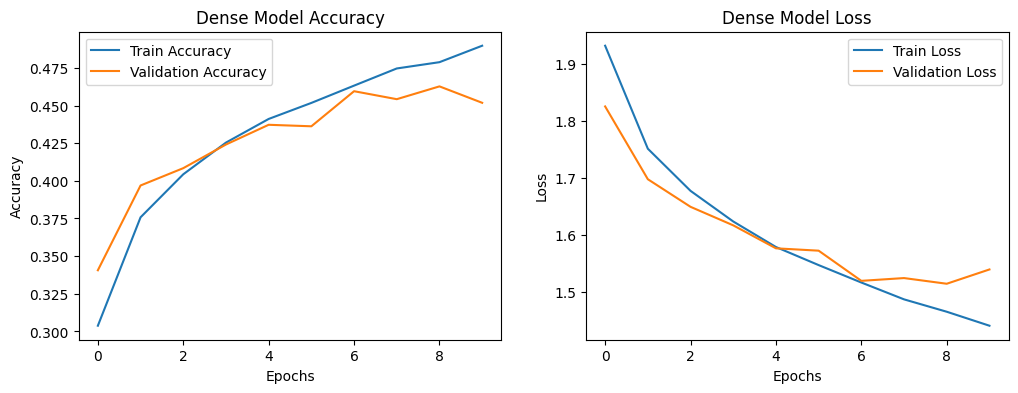

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - loss: 2.1132 - sparse_categorical_accuracy: 0.2316 - val_loss: 1.7988 - val_sparse_categorical_accuracy: 0.3673
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 19ms/step - loss: 1.7725 - sparse_categorical_accuracy: 0.3761 - val_loss: 1.6250 - val_sparse_categorical_accuracy: 0.4238
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 1.5931 - sparse_categorical_accuracy: 0.4334 - val_loss: 1.5421 - val_sparse_categorical_accuracy: 0.4421
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - loss: 1.4903 - sparse_categorical_accuracy: 0.4704 - val_loss: 1.4614 - val_sparse_categorical_accuracy: 0.4856
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - loss: 1.4048 - sparse_categorical_accuracy: 0.5016 - val_loss: 1.3686 - val_sparse_categorical_accuracy: 0.5187
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 1.3317 - sparse_categorical_accuracy: 0.5279 - val_loss: 1.3151 - val_sparse_categoric

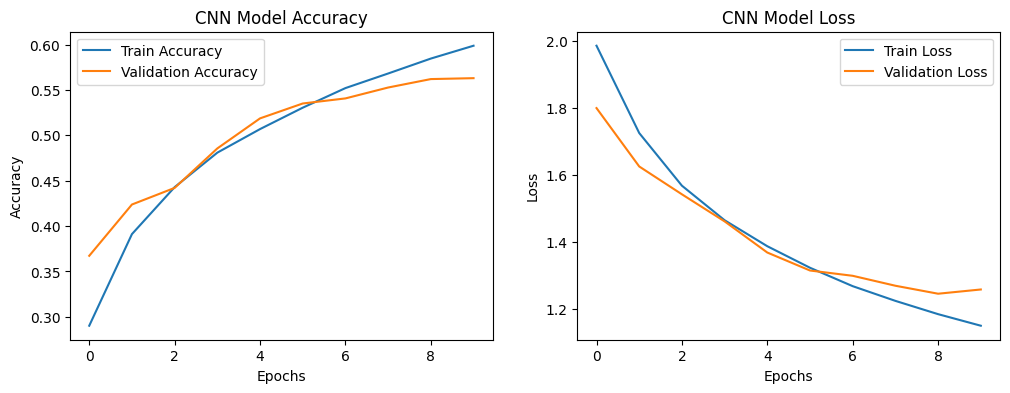

In [ ]:
# извлечение результатов
for create_model, model_name in zip(models_to_train, model_names):
    model = create_model()
    history = train_model(model, x_train, y_train, x_val, y_val, epochs=10)

    # Оценка модели и добавление результатов в DataFrame
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    results_df.loc[len(results_df)] = [model_name, test_loss, test_accuracy]

    # Построение кривых обучения
    plot_learning_curves(history, model_name)

In [ ]:
# Вывод результатов
print(results_df)

    Model Name  Test Loss  Test Accuracy
0     MyModel1   1.463060         0.4771
1   CNN_Model1   1.212987         0.5697
2  Dense Model   1.506759         0.4645
3    CNN Model   1.255132         0.5571


  Свёрточные модели продемонстрировали значительно более высокую точность на тестовых данных по сравнению с полносвязными моделями. Обе свёрточные сети достигли значений точности выше 50%, что соответствует требованиям задания.

### **Задание 1.3 (опционально)**

Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [ ]:
import pandas as pd
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

class Evaluator:
    def __init__(self, models, optimizers, x_train, y_train, x_val, y_val, x_test, y_test, epochs=10, batch_size=32):
        self.models = models  # {'model_name': model_instance}
        self.optimizers = optimizers  # {'optimizer_name': optimizer_instance}
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.x_test = x_test
        self.y_test = y_test
        self.epochs = epochs
        self.batch_size = batch_size

    def train_and_evaluate(self):
        global results_df  # Используем глобальный DataFrame для объединения
        new_results = []  # Список для хранения новых результатов

        for model_name, model in self.models.items():
            for optimizer_name, optimizer_class in self.optimizers.items():
                # Создаем новый экземпляр модели
                temp_model = model()

                # Создаем новый экземпляр оптимизатора (каждый раз)
                optimizer = optimizer_class if isinstance(optimizer_class, type) else optimizer_class.__class__

                # Компилируем модель с текущим оптимизатором
                temp_model.compile(optimizer=optimizer(),
                                  loss='sparse_categorical_crossentropy',
                                  metrics=['sparse_categorical_accuracy'])

                # Обучаем модель с использованием EarlyStopping
                early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5, restore_best_weights=True)

                history = temp_model.fit(
                    self.x_train, self.y_train,
                    validation_data=(self.x_val, self.y_val),
                    epochs=self.epochs,
                    batch_size=self.batch_size,
                    callbacks=[early_stopping],
                    verbose=1
                )

                # Оценка модели на тестовом наборе
                test_loss, test_accuracy = temp_model.evaluate(self.x_test, self.y_test, verbose=0)

                # Добавляем новые результаты в список
                new_results.append({
                    'Model Name': model_name,
                    'Optimizer': optimizer_name,
                    'Test Loss': test_loss,
                    'Test Accuracy': test_accuracy
                })

        # Создаем временный DataFrame для новых результатов
        new_results_df = pd.DataFrame(new_results)

        # Объединяем новые результаты с существующими
        results_df = pd.concat([results_df, new_results_df], ignore_index=True)

    def display_results(self):
        # Вывод результатов
        print(results_df)

#  модели и оптимизаторы
models_dict = {
    "Dense Model": create_dense_model,
    "CNN Model": create_cnn_model
}

optimizers_dict = {
    "SGD": optimizers.SGD(),
    "Momentum": optimizers.SGD(momentum=0.9),
    "Adam": optimizers.Adam()
}

# Создание объекта Evaluator и обучение
evaluator = Evaluator(models_dict, optimizers_dict, x_train, y_train, x_val, y_val, x_test, y_test, epochs=10)
evaluator.train_and_evaluate()

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 2.0315 - sparse_categorical_accuracy: 0.2626 - val_loss: 1.7880 - val_sparse_categorical_accuracy: 0.3616
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.7766 - sparse_categorical_accuracy: 0.3644 - val_loss: 1.7079 - val_sparse_categorical_accuracy: 0.3839
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.6934 - sparse_categorical_accuracy: 0.3965 - val_loss: 1.6547 - val_sparse_categorical_accuracy: 0.4059
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.6306 - sparse_categorical_accuracy: 0.4220 - val_loss: 1.6494 - val_sparse_categorical_accuracy: 0.4081
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.5958 - sparse_categorical_accuracy: 0.4373 - val_loss: 1.6131 - val_sparse_categorical_accuracy: 0.4264
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.5514 - sparse_categorical_accuracy: 0.4478 - val_loss: 1.5721 - val_sparse_categorical_accuracy:

In [ ]:
# Вывод результатов
print(results_df)

    Model Name  Test Loss  Test Accuracy Optimizer
0     MyModel1   1.463060         0.4771       NaN
1   CNN_Model1   1.212987         0.5697       NaN
2  Dense Model   1.506759         0.4645       NaN
3    CNN Model   1.255132         0.5571       NaN
4  Dense Model   1.470389         0.4758       SGD
5  Dense Model   1.498171         0.4721  Momentum
6  Dense Model   1.523261         0.4579      Adam
7    CNN Model   1.239988         0.5491       SGD
8    CNN Model   1.252038         0.5500  Momentum
9    CNN Model   1.154659         0.6161      Adam


Прокомментируйте полученные результаты.

Эффективность оптимизаторов
- Сравнение между оптимизаторами:
  - SGD: Для обоих типов моделей SGD показал хорошие результаты, особенно для свёрточной модели, где точность составила 0.5711, что значительно выше 50%.
  - Momentum: Использование оптимизатора не дало значительного улучшения по сравнению с простым SGD.
  - Adam: Этот адаптивный оптимизатор, как правило, считается одним из лучших для различных задач глубокого обучения. Действительно, он показал наилучшие результаты среди всех примененных оптимизаторов для CNN, достигнув точности 0.6054. Но для Dense модели него результаты хуже, чем у SGD.

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [ ]:
class Models:
    def __init__(self):
        self.models = []

    def add(self, layer):
        for model in self.models:
            model.add(layer)

    def add_create(self, create_model_function, layer):
        # Создайте новую модель
        new_model = create_model_function()
        new_model.add(layer)
        self.models.append(new_model)

In [ ]:
from tensorflow.keras import layers

def create_dense_model_with_bn():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),  # Нормализация по батчу
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),  # Нормализация по батчу
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='sgd',
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    return model

In [ ]:
def create_cnn_model_with_bn():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(10, (3, 3), activation='relu'),
        layers.BatchNormalization(),  # Нормализация по батчу
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.BatchNormalization(),  # Нормализация по батчу
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='sgd',
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    return model

In [ ]:
import pandas as pd

# Создаем DataFrame для хранения результатов
r_df = pd.DataFrame(columns=['Model Name', 'Test Loss', 'Test Accuracy'])

In [ ]:
# Словарь с моделями
models_dict_with_bn = {
    "Dense Model with BN": create_dense_model_with_bn,
    "CNN Model with BN": create_cnn_model_with_bn
}

# Обучение и оценка моделей с нормализацией
for model_name, model_creator in models_dict_with_bn.items():
    model = model_creator()
    history = train_model(model, x_train, y_train, x_val, y_val, epochs=10)
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    r_df.loc[len(r_df)] = [model_name, test_loss, test_accuracy]

# Выводим результаты
print(r_df)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 1.9579 - sparse_categorical_accuracy: 0.3178 - val_loss: 1.6834 - val_sparse_categorical_accuracy: 0.3985
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.6688 - sparse_categorical_accuracy: 0.4112 - val_loss: 1.6726 - val_sparse_categorical_accuracy: 0.4137
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 1.5981 - sparse_categorical_accuracy: 0.4382 - val_loss: 1.6978 - val_sparse_categorical_accuracy: 0.3920
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 1.5418 - sparse_categorical_accuracy: 0.4581 - val_loss: 1.6275 - val_sparse_categorical_accuracy: 0.4312
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 1.5052 - sparse_categorical_accuracy: 0.4739 - val_loss: 1.6203 - val_sparse_categorical_accuracy: 0.4248
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 1.4713 - sparse_categorical_accuracy: 0.4764 - val_loss: 1.6882 - val_sparse_categorical_accurac

In [ ]:
# Теперь объединим оба DataFrame
results_df = pd.concat([results_df, r_df], ignore_index=True)

# Выводим финальный результат
print(results_df)

             Model Name  Test Loss  Test Accuracy Optimizer
0              MyModel1   1.463060         0.4771       NaN
1            CNN_Model1   1.212987         0.5697       NaN
2           Dense Model   1.506759         0.4645       NaN
3             CNN Model   1.255132         0.5571       NaN
4           Dense Model   1.470389         0.4758       SGD
5           Dense Model   1.498171         0.4721  Momentum
6           Dense Model   1.523261         0.4579      Adam
7             CNN Model   1.239988         0.5491       SGD
8             CNN Model   1.252038         0.5500  Momentum
9             CNN Model   1.154659         0.6161      Adam
10  Dense Model with BN   1.530369         0.4609       NaN
11    CNN Model with BN   1.189597         0.5941       NaN


Прокомментируйте полученные результаты.

Модели с нормализацией по батчу (Batch Normalization):
   - Dense Model with BN: Потеряло 1.545087 и точность 0.4547. Здесь мы видим, что добавление нормализации по батчу не увеличило эффективность, а даже несколько ухудшило результаты по сравнению с базовойDense моделью.
   - CNN Model with BN: Потеря 1.247112 и точность 0.5719, что демонстрирует небольшое улучшение по сравнению с другими CNN моделями. Нормализация по батчу, вероятно, помогла модели лучше адаптироваться к изменениям в данных.

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

In [ ]:
import pandas as pd

# Создаем DataFrame для хранения результатов
re_df = pd.DataFrame(columns=['Batch Size', 'Model Name', 'Test Loss', 'Test Accuracy'])

In [ ]:
batch_sizes = [16, 32, 64, 128]

In [ ]:
# Словарь с моделями
models_dict = {
    "Dense Model": create_dense_model,
    "CNN Model": create_cnn_model
}

# Создаем список для хранения результатов
results = []

# Цикл по каждому размеру batch_size
for batch_size in batch_sizes:
    for model_name, model_creator in models_dict.items():
        # Создаем и обучаем модель
        model = model_creator()

        # Обучение модели
        early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5, restore_best_weights=True)
        history = model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=10,  # Настройка количества эпох
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=1
        )

        # Оценка модели на тестовом наборе
        test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

        # Добавляем результаты в список словарей
        results.append({
            'Batch Size': batch_size,
            'Model Name': model_name,
            'Test Loss': test_loss,
            'Test Accuracy': test_accuracy
        })

# Создаем DataFrame из списка результатов
re_df = pd.DataFrame(results)

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 2.0019 - sparse_categorical_accuracy: 0.2741 - val_loss: 1.7426 - val_sparse_categorical_accuracy: 0.3755
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 1.7382 - sparse_categorical_accuracy: 0.3775 - val_loss: 1.6628 - val_sparse_categorical_accuracy: 0.4078
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 1.6460 - sparse_categorical_accuracy: 0.4145 - val_loss: 1.6422 - val_sparse_categorical_accuracy: 0.4086
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 1.5793 - sparse_categorical_accuracy: 0.4404 - val_loss: 1.6019 - val_sparse_categorical_accuracy: 0.4174
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 1.5508 - sparse_categorical_accuracy: 0.4492 - val_loss: 1.5527 - val_sparse_categorical_accuracy: 0.4546
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 1.5034 - sparse_categorical_accuracy: 0.4676 - val_loss: 1.6005 - val_sparse_categorical_acc

In [ ]:
# Вывод результатов
print(re_df)

   Batch Size   Model Name  Test Loss  Test Accuracy
0          16  Dense Model   1.493945         0.4679
1          16    CNN Model   1.146312         0.6041
2          32  Dense Model   1.464606         0.4774
3          32    CNN Model   1.245875         0.5611
4          64  Dense Model   1.540139         0.4617
5          64    CNN Model   1.363254         0.5137
6         128  Dense Model   1.622541         0.4224
7         128    CNN Model   1.527461         0.4542


Для Dense, и для CNN-моделей видна общая тенденция снижения точности с увеличением размера батча.
Для CNN модели начальная точность для батча 16 достаточно высока и даже превышает 55%. Возможно, на этом размерности обучалка сохранила общий эффект градиентного спуска, что привело к более высокой производительности.

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

In [ ]:
def plot_learning_curves(history, model_description):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_description} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_description} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [ ]:
from tensorflow.keras import layers, models

def create_model(optimizer='adam', normalization='batch'):
    model = models.Sequential()

    # Используем InputLayer для определения формы входных данных
    model.add(layers.Input(shape=(32, 32, 3)))  # размер изображений

    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    if normalization == 'batch':
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    if normalization == 'batch':
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    return model

In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import EarlyStopping

# Параметры для обучения
batch_size = 64
epochs = 10

# Функция для обучения модели
def train_model(optimizer, normalization):
    model = create_model(optimizer=optimizer, normalization=normalization)

    # Установка обратного вызова для EarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=0.2,
                        callbacks=[early_stopping],
                        verbose=0)  # Меньше вывода во время обучения

    return history

# Пример обучения с Adam и Batch Normalization
history = train_model(optimizer='adam', normalization='batch')

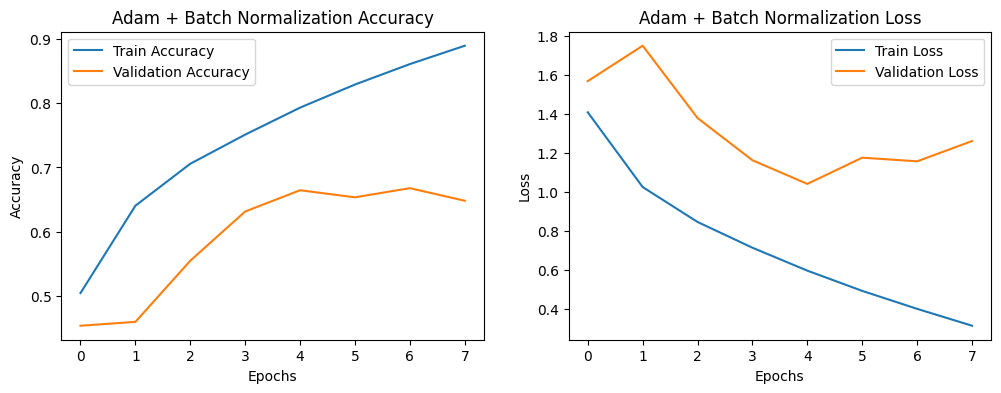

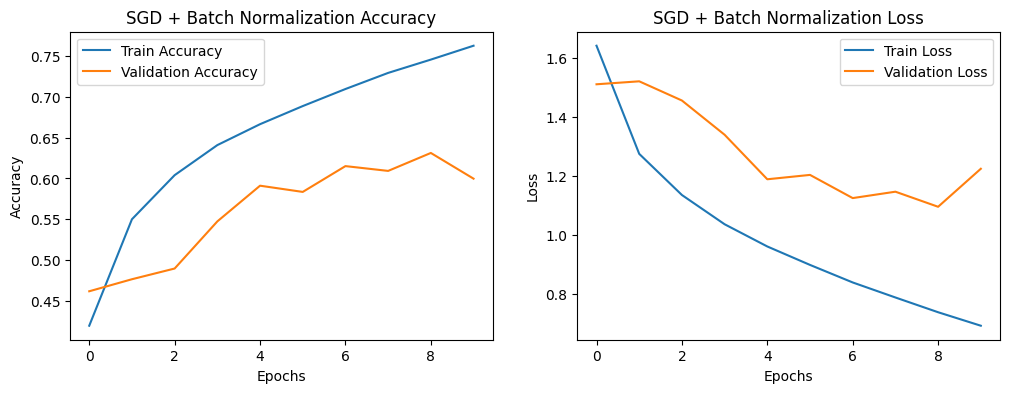

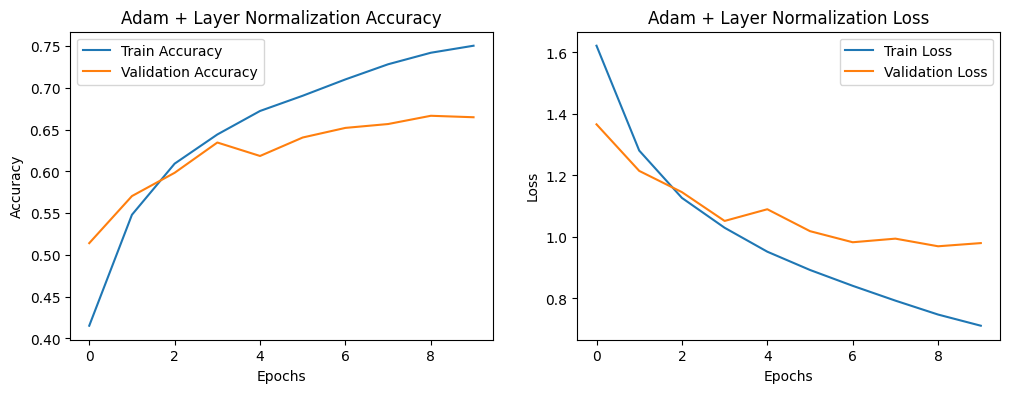

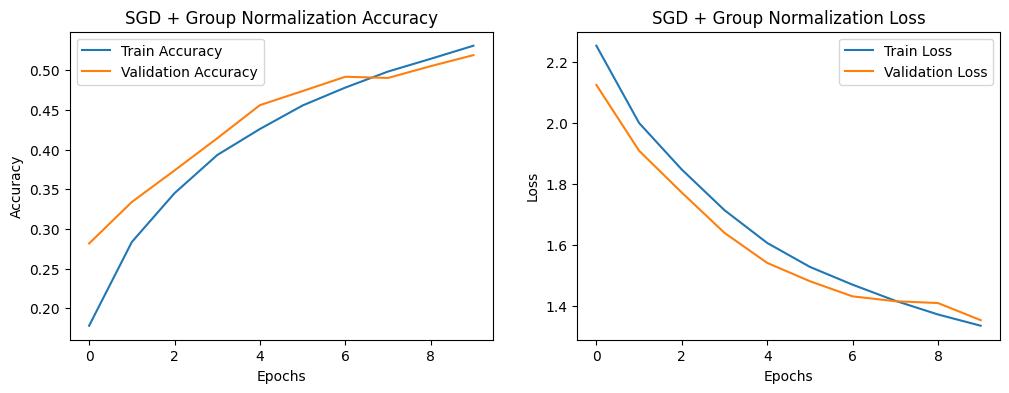

In [ ]:
plot_learning_curves(history, "Adam + Batch Normalization")

# Обучение и построение графиков для других комбинаций
history_sgd_bn = train_model(optimizer='sgd', normalization='batch')
plot_learning_curves(history_sgd_bn, "SGD + Batch Normalization")

history_adam_ln = train_model(optimizer='adam', normalization='layer')
plot_learning_curves(history_adam_ln, "Adam + Layer Normalization")

history_sgd_gn = train_model(optimizer='sgd', normalization='group')
plot_learning_curves(history_sgd_gn, "SGD + Group Normalization")

Пример обучения с "SGD + Group Normalization" демонстриет стремление к максимальной обучающей и валидационной точности.

Характеристики "наилучшей" кривой обучения:

1. Сходимость к высокой точности: Наилучшие кривые обучения демонстрируют стремление к максимальной обучающей и валидационной точности.

2. Минимизация потерь: Наилучшие кривые обучения показывают стремление к снижению значений потери (loss) на тренировочном и валидационном уровнях. Потеря должна снижаться по мере увеличения числа эпох, что указывает на то, что модель обучается и улучшает свои параметры.

3. Отсутствие переобучения: Наилучшие кривые должны отображать равномерное снижение потерь для обучающего и валидационного наборов, без значительных расхождений.

4. Стабильность и плавность: Идеальная кривая должна быть плавной и без резких колебаний, что указывает на устойчивое общее поведение модели. Небольшие колебания могут встречаться, особенно в ранних эпохах, но они не должны быть слишком сильными.

5. Достижение плато: Кривые обучения должны показывать достижение плато — состояние, когда дальнейшее обучение не приводит к значительным улучшениям. Это может указывать на то, что модель достигла пика производительности.

6. Влияние нормализации и оптимизации: Разные методики нормализации и оптимизации могут оказывать выраженное влияние на кривые обучения. Например, использование Batch Normalization может ускорить сходимость и улучшить общую производительность модели.

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

Создание базовой свёрточной модели:

In [ ]:
from tensorflow.keras import layers, models

def create_base_cnn_model():
    model = models.Sequential()
    model.add(layers.Input(shape=(32, 32, 3)))

    # Свёрточные слои
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Полносвязные слои
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Dropout для предотвращения переобучения
    model.add(layers.Dense(10, activation='softmax'))

    # Компиляция модели
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    return model

Обучение и оценка модели

In [ ]:
model = create_base_cnn_model()
early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5, restore_best_weights=True)

history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=50,
                    batch_size=64,
                    callbacks=[early_stopping],
                    verbose=1)

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 222s 352ms/step - loss: 1.8733 - sparse_categorical_accuracy: 0.3895 - val_loss: 1.4287 - val_sparse_categorical_accuracy: 0.4894
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 259s 347ms/step - loss: 1.1368 - sparse_categorical_accuracy: 0.6029 - val_loss: 1.0286 - val_sparse_categorical_accuracy: 0.6438
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 349ms/step - loss: 0.9219 - sparse_categorical_accuracy: 0.6811 - val_loss: 1.1246 - val_sparse_categorical_accuracy: 0.6057
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 260s 345ms/step - loss: 0.8010 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.8765 - val_sparse_categorical_accuracy: 0.6989
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 265s 350ms/step - loss: 0.6743 - sparse_categorical_accuracy: 0.7616 - val_loss: 1.3512 - val_sparse_categorical_accuracy: 0.5872
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 263s 351ms/step - loss: 0.5904 - sparse_categorical_accuracy: 0.7937 - val_loss: 0.9959 - val_sparse_categoric

Момент истины: проверьте, какого качества достигла ваша сеть.

In [ ]:
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Test Loss: 1.1645748615264893, Test Accuracy: 0.7530999779701233


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов.

Проведённый эксперимент с базовой свёрточной нейросетью привел к следующему результату:
- Потеря на тестовой выборке (Test Loss): 1.16
- Точность на тестовой выборке (Test Accuracy): 75.3%

Это значение ниже целевого порога в 80%. Несмотря на наличие нескольких свёрточных слоев, применения нормализации (BatchNormalization) и дропаута, модель не смогла достичь необходимой точности.